In [43]:
# load data
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [44]:
# Data Preparation 
data = pd.read_csv('dairy_output.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_name   4325 non-null   object 
 1   revenue        4325 non-null   float64
 2   qty_sold       4325 non-null   int64  
 3   cust_location  4325 non-null   object 
 4   cows_number    4325 non-null   int64  
 5   farm_size      4325 non-null   object 
 6   price_unit     4325 non-null   float64
 7   shelf_life     4325 non-null   int64  
 8   storage        4325 non-null   int64  
 9   channel        4325 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 338.0+ KB


In [45]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
revenue,4325.0,13580.265401,14617.009122,12.54,2916.65,8394.54,19504.55,89108.90
qty_sold,4325.0,248.095029,217.024182,1.00,69.00,189.00,374.00,960.00
cows_number,4325.0,54.963699,26.111487,10.00,32.00,55.00,77.00,100.00
price_unit,4325.0,54.779140,26.192790,5.21,32.64,54.14,77.46,104.51
shelf_life,4325.0,29.127630,30.272114,1.00,10.00,22.00,30.00,150.00
storage,4325.0,0.807861,0.394027,0.00,1.00,1.00,1.00,1.00
channel,4325.0,0.316994,0.465359,0.00,0.00,0.00,1.00,1.00


In [46]:
# detecting missing values in the dataset
data.isnull().sum()

product_name     0
revenue          0
qty_sold         0
cust_location    0
cows_number      0
farm_size        0
price_unit       0
shelf_life       0
storage          0
channel          0
dtype: int64

In [47]:
# PREANALYSIS
data.groupby('channel')["revenue"].sum()

channel
0    41078254.38
1    17656393.48
Name: revenue, dtype: float64

Null hypothesis : Revenue dari online sales dan offline sales adalah sama
Alternate hypothesis : Revenue dari online sales dan offline sales tidak sama

- gunakan t-test karena tidak mengetahui population standar deviation 
- Before conducting the two-sample t-test we need to find if the given data groups have the same variance.


In [9]:
# revenue on online sales
data_group1 = data[data['channel']==0]['revenue'].values

# bike rent on weekend
data_group2 = data[data['channel']==1]['revenue'].values

# variance 
np.var(data_group1), np.var(data_group2)

(224177795.94752932, 190111494.70764568)

Berdasarkan hasil, variance tidak sama di kedua sampel

In [10]:
from scipy import stats
result = stats.ttest_ind(a = data_group1, 
                         b = data_group2, 
                         equal_var=False, 
                         alternative = "greater")

In [11]:
result.pvalue

0.013330077493455222

In [12]:
result.statistic

2.2175964264266272

In [13]:
# Menentukan aturan keputusan
if result.pvalue<0.05:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the Null hypothesis")

Reject the null hypothesis


In [15]:
# Degree of freedom from two samples 
df_data = len(data_group1)+len(data_group2)-2
df_data

4323

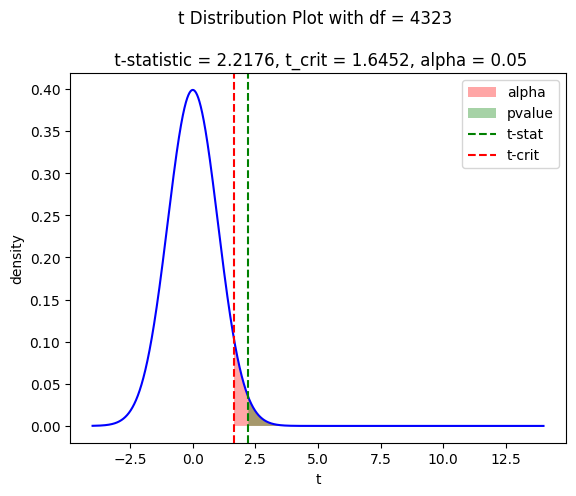

In [16]:
# plot sample distribution 
x = np.arange(-4, 14, 0.001)
plt.plot(x, stats.t.pdf(x, df = df_data), 
         color='blue')

# plot alpha region
x_alpha = np.arange(stats.t.ppf(1-0.05, df = df_data), 4, 0.01)
y_alpha = stats.t.pdf(x_alpha, df = df_data)
plt.fill_between(x = x_alpha, 
                 y1 = y_alpha,
                 facecolor = 'red',
                 alpha = 0.35, 
                 label = 'alpha')

# plot pvalue
x_pvalue = np.arange(result.statistic, 4, 0.01)
y_pvalue = stats.t.pdf(x_pvalue, df = df_data)

plt.fill_between(x = x_pvalue, 
                 y1 = y_pvalue,
                 facecolor = 'green',
                 alpha = 0.35, 
                 label = 'pvalue')

# plot t-crit and t-stats
plt.axvline(np.round(result.statistic, 4), 
            color ="green", 
            linestyle = "--", 
            label ="t-stat")

t_crit = np.round(stats.t.ppf(1-0.05, df = df_data), 4)
plt.axvline(t_crit, 
            color ="red", 
            linestyle = "--", 
            label ="t-crit")

plt.legend()
plt.xlabel("t")
plt.ylabel("density")


plt.title(f't Distribution Plot with df = {df_data} \n\n t-statistic = {np.round(result.statistic, 4)}, t_crit = {np.round(t_crit,4)}, alpha = 0.05');

In [17]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

cm = CompareMeans(d1 = DescrStatsW(data=data_group1), 
                  d2 = DescrStatsW(data=data_group2))

lower, upper = cm.tconfint_diff(alpha=0.05, 
                                alternative='two-sided', 
                                usevar='unequal')

print("Confidence Interval", ":", "[", lower, upper, "]")

Confidence Interval : [ 118.98917349022497 1936.0074832750342 ]


Based on the result, we can 95% confident that the average difference the online sales and offline sales revenue between 118.9 and 1936.00.

Conclusion
- As the p value < alpha(0.05) , we reject 𝐻0
. Therefore, we can say that the revenue from online sales and offline sales is not equal

In [21]:
# modelling
import statsmodels.formula.api as smf

# statistics 
import scipy.stats as stats

In [22]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from 
    :return df: <pandas DataFrame> 
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

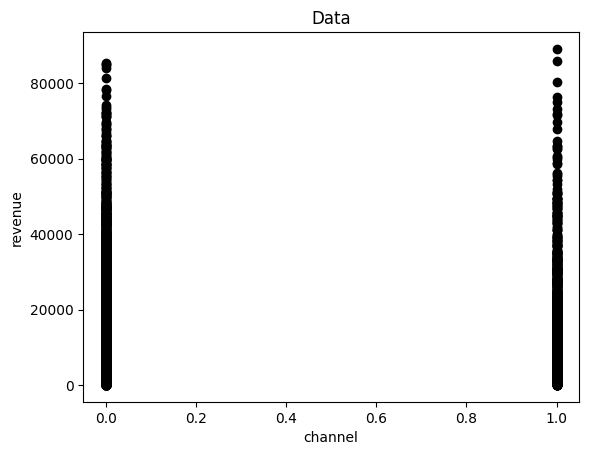

In [19]:
# Regression Model
# relationship between revenue and sales channel

x = data['channel']
y = data['revenue']

# Plot the data
plt.scatter(x, y, color = "k")

# Add a legend and labels

plt.xlabel("channel")
plt.ylabel("revenue")

# Add a title and adjust the margins
plt.title("Data")

# Show the plot
plt.show()

not much difference between 0 (offline) and 1 (online)

In [23]:
# Fit Linear Regression

# Create OLS model object
model = smf.ols('revenue ~ channel', data)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_channel_revenue = print_coef_std_err(results)

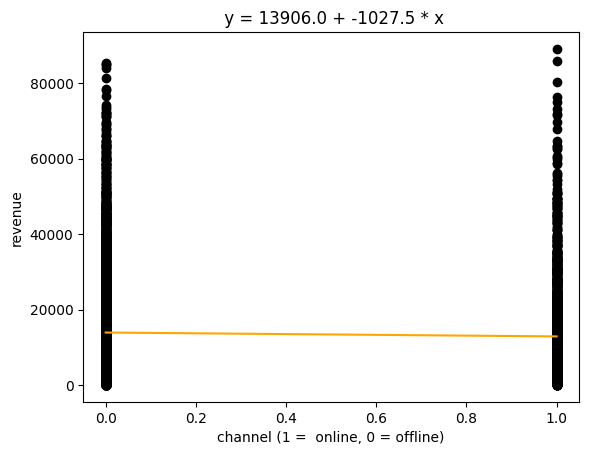

In [24]:
predictor = "channel"
outcome = "revenue"
data = data.copy()
results_ = results_channel_revenue.copy()

# scatter-plot data
x = data['channel']
y = data['revenue']

# Plot the data
plt.scatter(x, y, color = "k")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "orange")

plt.ylabel("revenue")
plt.xlabel("channel (1 =  online, 0 = offline)")
plt.title(f" y = {np.round(a_hat)} + {np.round(b_hat, 2)} * x")

plt.show()

In [25]:
results_channel_revenue

,coef,std err
Intercept,13905.976432,268.825836
channel,-1027.498328,477.469169


The average of the revenue from the offline sales is 13906
the difference between average of revenue in online sales and offline sales is -1027.5

Now we want to know relationship with other variables. First, how price unit related to revenue


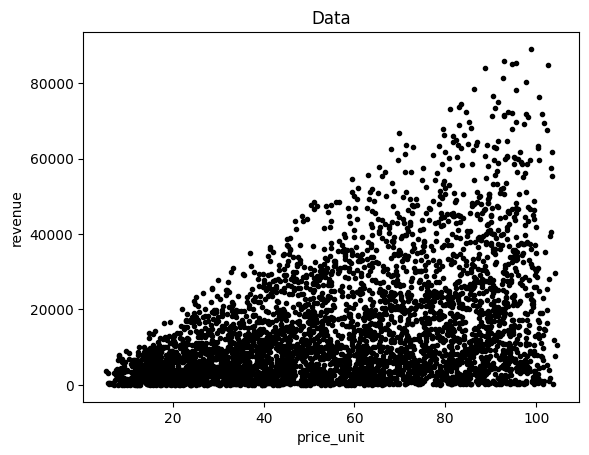

In [89]:
x = data['price_unit']
y = data['revenue']

# Plot the data
plt.scatter(x, y, color = "k", marker=".")

# Add a legend and labels

plt.xlabel("price_unit")
plt.ylabel("revenue")

# Add a title and adjust the margins
plt.title("Data")

# Show the plot
plt.show()

In [90]:
# fit linear regression
# Create OLS model object
model = smf.ols('revenue ~ price_unit', data)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_qty_sold_revenue = print_coef_std_err(results)

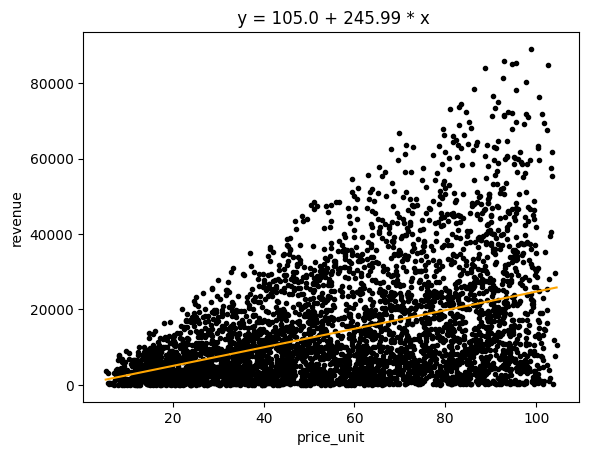

In [91]:
predictor = "price_unit"
outcome = "revenue"
data = data.copy()
results_ = results_qty_sold_revenue.copy()

# scatter-plot data
x = data['price_unit']
y = data['revenue']

# Plot the data
plt.scatter(x, y, color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "orange")

plt.ylabel("revenue")
plt.xlabel("price_unit")
plt.title(f" y = {np.round(a_hat)} + {np.round(b_hat, 2)} * x")

plt.show()

Qty_sold and storage condition vs revenue

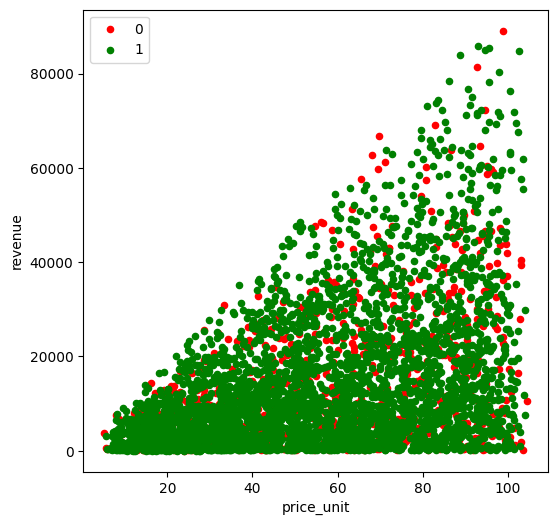

In [94]:
# Shelf life and storage condition vs revenue

fig, ax = plt.subplots(figsize=(6, 6))

# Define different color for each group data
colors = {0:"r", 1:"g"}

grouped = data.groupby('storage')

# Plot the data with different color
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='price_unit', y='revenue', label=key, color=colors[key])
plt.show()

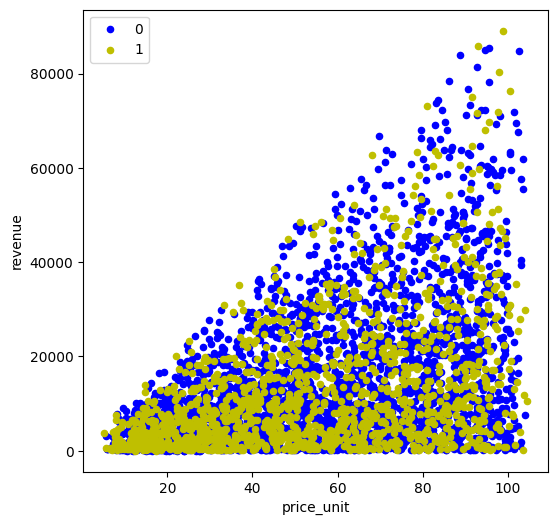

In [95]:
# QPrice_unit and sales channel vs revenue
fig, ax = plt.subplots(figsize=(6, 6))

# Define different color for each group data
colors = {0:"b", 1:"y"}

grouped = data.groupby('channel')

# Plot the data with different color
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='price_unit', y='revenue', label=key, color=colors[key])
plt.show()

In [56]:
data["farm_size"].value_counts()

farm_size
Large     1462
Medium    1439
Small     1424
Name: count, dtype: int64

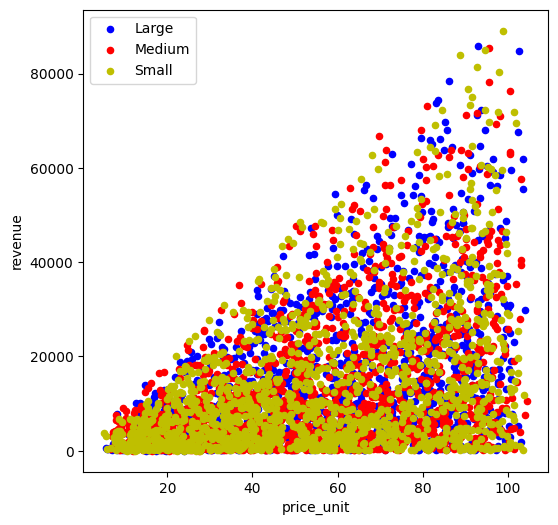

In [96]:
fig, ax = plt.subplots(figsize=(6, 6))

# Define different color for each group data

colors = {"Large":"b", "Medium":"r", "Small":"y"}

grouped = data.groupby('farm_size')
# Plot the data with different color
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='price_unit', y='revenue', label=key, color=colors[key])
plt.show()

 Shelf life and storage condition vs revenue paling jelas perbedaannya. Visualisasi data dan garis regresi

In [97]:
# Create OLS model object
model = smf.ols('revenue ~ price_unit + channel', data)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_price_channel_revenue = print_coef_std_err(results)

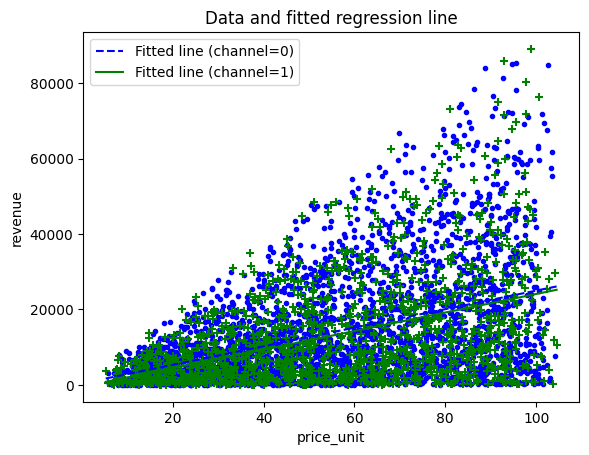

In [98]:
predictors = ["price_unit","channel"]
outcome = "revenue"
data = data.copy()
results_ = results_price_channel_revenue.copy()
linestyles = {0 : "--", 1: "-"}
c = {0 : "b", 1: "g"}
markers = {0 : ".", 1: "+"}

# Plot the data
for i in range(2):
    plt.scatter(data[data[predictors[1]]==i][predictors[0]], data[data[predictors[1]]==i][outcome], 
                color = c[i], 
                marker = markers[i])
    
x_domain = np.linspace(np.min(data[predictors[0]]), np.max(data[predictors[0]]), 100)


# Calculate the fitted values for two lines regarding the mom_hs
beta0_hat = results_.loc["Intercept"]["coef"]
beta1_hat = results_.loc[predictors[0]]["coef"]
beta2_hat = results_.loc[predictors[1]]["coef"]

fitted_values = [beta0_hat +  beta1_hat * x_domain  + beta2_hat * i for i in range(2)]


# Plot two fitted line
for i in range(2):
    plt.plot(x_domain, fitted_values[i], c = c[i], label = f"Fitted line (channel={i})", linestyle = linestyles[i])

# Add a legend and labels
plt.legend()
plt.ylabel(f"{outcome}")
plt.xlabel(f"{predictors[0]}")

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

Still have same slopes, and why the line is same??

In [103]:
results_price_channel_revenue

,coef,std err
Intercept,394.652859,483.188280
price_unit,245.825911,7.616053
channel,-884.935512,428.670545


In [99]:
# Create OLS model object
model = smf.ols('revenue ~ price_unit + channel + channel:price_unit', data)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_price_unit_channel_revenue = print_coef_std_err(results)

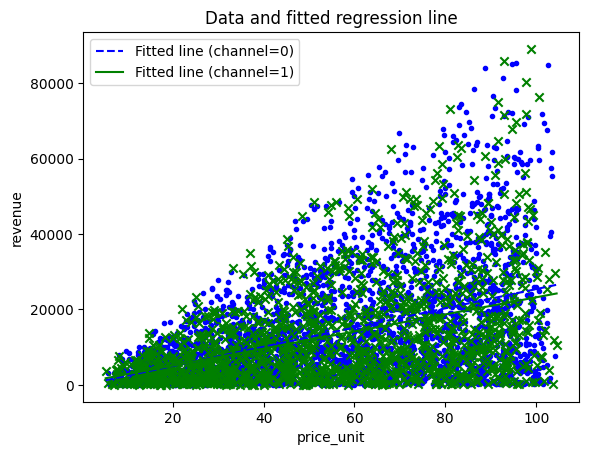

In [100]:
predictors = ["price_unit","channel","channel:price_unit"]
outcome = "revenue"
data = data.copy()
results_ = results_price_unit_channel_revenue.copy()
linestyles = {0 : "--", 1: "-"}
c = {0 : "b", 1: "g"}
markers = {0 : ".", 1: "x"}

# Plot the data
for i in range(2):
    plt.scatter(data[data[predictors[1]]==i][predictors[0]], data[data[predictors[1]]==i][outcome], 
                color = c[i], marker = markers[i])

# Calculate the fitted values for two lines regarding the mom_hs
beta0_hat = results_.loc["Intercept"]["coef"]
beta1_hat = results_.loc[predictors[0]]["coef"]
beta2_hat = results_.loc[predictors[1]]["coef"]
beta3_hat = results_.loc[predictors[2]]["coef"]

fitted_values = [beta0_hat +  beta1_hat * x_domain  + beta2_hat * i + beta3_hat * i * x_domain for i in range(2)]

x_domain = np.linspace(np.min(data[predictors[0]]), np.max(data[predictors[0]]), 100)

# Plot two fitted line
for i in range(2):
    plt.plot(x_domain, fitted_values[i], c = c[i], label = f"Fitted line (channel={i})", linestyle = linestyles[i])

# Add a legend and labels
plt.legend()
plt.ylabel(f"{outcome}")
plt.xlabel(f"{predictors[0]}")

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

In [102]:
results_price_unit_channel_revenue


,coef,std err
Intercept,-99.775954,560.533330
price_unit,254.821582,9.205203
channel,669.452822,991.270050
channel:price_unit,-28.486296,16.380781
